In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import time
import os
from pathlib import Path
import numpy as np
import random

In [3]:
# initializing MTCNN and InceptionResnetV1 

mtcnn0 = MTCNN(image_size=240, margin=0, keep_all=False, min_face_size=40) # keep_all=False
mtcnn = MTCNN(image_size=240, margin=0, keep_all=True, min_face_size=40) # keep_all=True
resnet = InceptionResnetV1(pretrained='vggface2').eval() 

In [4]:
# Get image folders
PATH = Path("images")
paths = sorted([x for x in list((PATH).iterdir()) if x.is_dir()])
paths

[PosixPath('images/henry'),
 PosixPath('images/kohli'),
 PosixPath('images/melvin'),
 PosixPath('images/train-300'),
 PosixPath('images/valid-300')]

In [5]:
## all files
files = [f for d in paths for f in list(d.iterdir())]
len(files)
files[0:3]

[PosixPath('images/henry/NINTCHDBPICT000623572784.webp'),
 PosixPath('images/henry/Henry_Cavill.jpeg'),
 PosixPath('images/henry/10-6B8CC7DC-EA77-48E0-A6D2-A72CCB4E4AC6.png')]

In [6]:
# here is how you get the class
labels = [p.parts[-1] for p in paths]
labels

['henry', 'kohli', 'melvin', 'train-300', 'valid-300']

In [7]:
{v:k for k, v in enumerate(labels)}

{'henry': 0, 'kohli': 1, 'melvin': 2, 'train-300': 3, 'valid-300': 4}

In [8]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [9]:
def resize_images(path, sz=300):
    im = read_image(path)
    sz2 = int(0.8*sz)
    return cv2.resize(im, (sz2, sz))

In [10]:
train_path = PATH/"train-300"
valid_path = PATH/"valid-300"

train_path.mkdir(exist_ok=True)
valid_path.mkdir(exist_ok=True) 

In [11]:
def resize_all_images(train_path, valid_path, org_path, sz=300):
    np.random.seed(3)
    paths = [x for x in list(org_path.iterdir()) if x.is_dir() 
             and x not in  [Path('images/train-300'), Path('images/valid-300')]]
    print(paths)
    for p in paths:
        label = p.parts[-1]
        (train_path/label).mkdir(exist_ok=True)
        (valid_path/label).mkdir(exist_ok=True) 
        files = list((org_path/label).iterdir())
        for f in files:
            f_name = f.parts[-1]
            if np.random.uniform() < 0.8:
                new_path = train_path/label/f_name
            else:
                new_path = valid_path/label/f_name
            try:
                im = resize_images(f)
                cv2.imwrite(str(new_path), cv2.cvtColor(im, cv2.COLOR_RGB2BGR))
            except:
                pass

In [12]:
# resize_all_images(train_path, valid_path, PATH)

In [13]:
# checking
# for label in labels:
#     all_files = len(list((PATH/label).iterdir()))
#     train_files = len(list((train_path/label).iterdir()))
#     valid_files = len(list((valid_path/label).iterdir()))
#     print(label, all_files, train_files, valid_files)

In [14]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [15]:
# modified from fast.ai
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [16]:
class ImageDataset(Dataset):
    def __init__(self, PATH, train="train-300", transforms=False):
        self.path_to_images = PATH/train
        self.transforms = transforms
        self.paths = sorted([x for x in list(self.path_to_images.iterdir()) if x.is_dir()])
        self.files = [f for d in self.paths for f in list(d.iterdir())]
        self.labels = [p.parts[-1] for p in self.paths]
        self.label2ind = {v:k for k,v in enumerate(self.labels)}
        self.ind2label = {k:v for k,v in enumerate(self.labels)}        
        self.len = len(self.files)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        path = self.files[idx] 
        x = Image.open(path)
        # x = cv2.imread(str(path)).astype(np.float32)
        # x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        # if self.transforms:
        #     rdeg = (np.random.random()-.50)*20
        #     x = rotate_cv(x, rdeg)
        #     if np.random.random() > 0.5: x = np.fliplr(x).copy()
        #     x = random_crop(x)
        # else:
        #     x = center_crop(x)
        # # x = normalize(x)
        # plt.imshow(x)      
        y = self.label2ind[path.parts[-2]]
        # return np.rollaxis(x, 2), y
        return x, y

In [17]:
train_ds = ImageDataset(PATH, "train-300", transforms=True)
valid_ds = ImageDataset(PATH, "valid-300")

In [18]:
len(train_ds), len(valid_ds)

(32, 6)

In [19]:
# batch_size = 1
# train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# valid_dl = DataLoader(valid_ds, batch_size=batch_size)

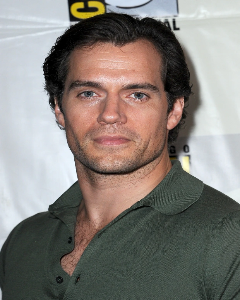

In [20]:
# run this multiple times to get different images
x, y = train_ds[0]
# plt.imshow(np.moveaxis(x, 0, 2), cmap='gray')
# img, label = next(iter(train_ds))
x

In [21]:
# # Resizing image while maintaining aspect ratio
# img = Image.open(path)
# width, height = img.size
# ratio = width / height
# new_height = 300
# new_width = int(ratio * new_height)
# img = img.resize((new_width, new_height))
# img

In [22]:
train_ds.labels

['henry', 'kohli', 'melvin']

In [23]:
name_list = [] # list of names corrospoing to cropped photos
embedding_list = [] # list of embeding matrix after conversion from cropped faces to embedding matrix using resnet

for img, idx in train_ds:
    face, prob = mtcnn0(img, return_prob=True) 
    if face is not None and prob>0.92:
        emb = resnet(face.unsqueeze(0)) 
        embedding_list.append(emb.detach()) 
        name_list.append(train_ds.ind2label[idx])        

# save data
data = [embedding_list, name_list] 
torch.save(data, 'data.pt') # saving data.pt file

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


In [24]:
load_data = torch.load('data.pt') 
embedding_list = load_data[0] 
name_list = load_data[1] 

In [89]:
vds = iter(valid_ds)

In [100]:
img = next(vds)[0]
img

StopIteration: 

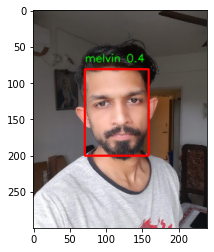

In [99]:
img_cropped_list, prob_list = mtcnn(img, return_prob=True) 
boxes, _ = mtcnn.detect(img)
emb = resnet(img_cropped_list).detach() 

dist_list = []
for idx, emb_db in enumerate(embedding_list):
    dist = torch.dist(emb, emb_db).item()
    dist_list.append(dist)
min_dist = min(dist_list) # get minumum dist value
min_dist_idx = dist_list.index(min_dist) # get minumum dist index
name = name_list[min_dist_idx] # get name corrosponding to minimum dist

box = boxes[0]
np_img = np.array(img)
frame = cv2.putText(np_img, 
                    name + ' ' + str(round(min_dist, 2)), 
                    (int(box[0]), int(box[1]) - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, 
                    (0,255,0),
                    1, 
                    cv2.LINE_AA)
frame = cv2.rectangle(np_img, 
                        (int(box[0]), int(box[1])) , 
                        (int(box[2]), int(box[3])), 
                        (255,0,0), 
                        2)      
plt.imshow(frame)                                      

In [101]:
cam = cv2.VideoCapture(0) 

while True:
    ret, frame = cam.read()
    if not ret:
        print("fail to grab frame, try again")
        break
        
    img = Image.fromarray(frame)
    img_cropped_list, prob_list = mtcnn(img, return_prob=True) 
    
    if img_cropped_list is not None:
        boxes, _ = mtcnn.detect(img)
                
        for i, prob in enumerate(prob_list):
            if prob>0.90:
                emb = resnet(img_cropped_list[i].unsqueeze(0)).detach() 
                
                dist_list = [] # list of matched distances, minimum distance is used to identify the person
                
                for idx, emb_db in enumerate(embedding_list):
                    dist = torch.dist(emb, emb_db).item()
                    dist_list.append(dist)

                min_dist = min(dist_list) # get minumum dist value
                min_dist_idx = dist_list.index(min_dist) # get minumum dist index
                name = name_list[min_dist_idx] # get name corrosponding to minimum dist
                
                box = boxes[i] 
                
                original_frame = frame.copy() # storing copy of frame before drawing on it
                
                if min_dist<0.90:
                    frame = cv2.putText(frame, name+' '+str(min_dist), (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),1, cv2.LINE_AA)
                
                frame = cv2.rectangle(frame, (int(box[0]), int(box[1])) , (int(box[2]), int(box[3])), (255,0,0), 2)

    cv2.imshow("IMG", frame)
        
    
    k = cv2.waitKey(1)
    if k%256==27: # ESC
        print('Esc pressed, closing...')
        break
        
    elif k%256==32: # space to save image
        print('Enter your name :')
        name = input()
        
        # create directory if not exists
        if not os.path.exists('photos/'+name):
            os.mkdir('photos/'+name)
            
        img_name = "photos/{}/{}.jpg".format(name, int(time.time()))
        cv2.imwrite(img_name, original_frame)
        print(" saved: {}".format(img_name))
        
        
cam.release()
cv2.destroyAllWindows()
    

2022-01-09 22:45:09.725 python[81450:2628704] Warning: Window move completed without beginning


Esc pressed, closing...
